<a href="https://colab.research.google.com/github/Geethen/Indibano_2023_spatialML/blob/main/notebooks/2.%20Intermediate%20GEE-ML%20workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning with the Google Earth Engine Python API

### Motivation
Using Google Earth Engine (GEE) through the python API (as opposed to the JS API) provides users with greater flexibility and easier access to python, R and Julia functionality if used through project Jupyter (reccommended).

In the upcoming notebooks, users will be taken through getting started with GEE Machine Learning (ML) in python for Earth Observation (EO) based ecological applications.

### Pre-requisites

* A Google Earth Engine (GEE) Account
* A basic grasp of coding concepts (variables, functions, for loops and if statements).

## Part 2: Introduction

After going through this notebook, you will know:

    1. How to repeat the previous GEE workflow by combining thebenefits of python and the cloud computing capabilities of GEE.

In these tutorials, we will use:

   * Google colab - A freely available cloud hosted jupyter notebook
   * geemap - A python package that makes the use of GEE in python easier

## Install packages

Since we are using Google colab we can skip the setup of a virtual environment and proceed by installing additional packages not  available by default in the Google Colab environment. Once complete, restart the runtime.  

watermark is a useful package to print out the python version and loaded package versions

In [1]:
# Install packages not available in colab
%pip install watermark geedim localtileserver -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires f

## Import packages

In [2]:
# Load watermark package
%load_ext watermark

In [4]:
# Import and initialize Google Earth Engine. When running this cell in colab, you will always be prompted to authenticate first.
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

# Import geemap - a package that includes lots of utility fucntions to make working with GEE in python easier
import geemap

import os
# Matplotlib is the de facto visualisation package in python
import matplotlib.pyplot as plt

In [5]:
# Prints the python version and the imported package versions
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.120+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

geemap    : 0.28.2
ee        : 0.1.374
matplotlib: 3.7.1



## Initialise an interactive map

A geemap Map object provides an interactive map that allows users to explore GEE data within a jupyter notebook. This Map object also has numerous additional builtin functionality that allows users to:  
1. Search the earth engine catalog  
2. Change the basemap  
3. Draw areas on the map that are then accessible via the EE API  
4. Load locally stored vector and raster data  
5. Inspect/query the layers that are shown  

Once you run the code cell below, hover over the widgets on the top left and right. The globe widget on the top left, allows users to search for earth engine datasets or places using their names or latitudes and longitudes. The tool widget on the top right has a lot more functionality which you can find out more about in the key features section [here](https://geemap.org/).

In [6]:
# Create an interactive map
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## 01. Basic supervised classification

We will learn how to do a basic land cover classification using training samples collected from the Code Editor using the High Resolution basemap imagery provided by Google Maps. This method is quite effective to generate high quality classification samples anywhere in the world.

The goal is to classify each source pixel into one of the following classes:

- Urban
- Bare
- Water
- Vegetation

Specifically, using the drawing tools in the map,  4 new feature collections with points representing pixels of that class were created. Each feature collection has a property called landcover with values of 0, 1, 2 or 3 indicating whether the feature collection represents urban, bare, water or vegetation respectively.

We then train a Random Forest classifier using this training set to build a model and apply it to all the pixels of the image to create a 4 class image.

In [7]:
# Load Bangolore boundary
bangalore = ee.FeatureCollection("users/ujavalgandhi/public/bangalore_boundary")
# Load Sentinel-2 atmospherically corrected data
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

# The following collections were created using the
# Drawing Tools in the code editor
urban = ee.FeatureCollection("users/ujavalgandhi/e2e/urban_gcps")
bare = ee.FeatureCollection("users/ujavalgandhi/e2e/bare_gcps")
water = ee.FeatureCollection("users/ujavalgandhi/e2e/water_gcps")
vegetation = ee.FeatureCollection("users/ujavalgandhi/e2e/vegetation_gcps")

# Filter Sentinel-2 data
# Select images with less than 30% cloud cover
# Select images for 2019. end-date is exclusive
# Select images that overlap the bangalore boundary
# Select all bands starting with the letter 'B'
filtered = s2\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
    .filter(ee.Filter.date('2019-01-01', '2020-01-01'))\
    .filter(ee.Filter.geometry(bangalore))\
    .select('B.*')

# Using all remaining images after filtering, compute the median and clip to the boundary of the bangalore boundary
composite = filtered.median().clip(bangalore)

# Define the visualisation parameters to display the input composite.
rgbVis = {
  "min": 0.0,
  "max": 3000,
  "bands": ['B4', 'B3', 'B2'],
}

Map.centerObject(urban.first(), 9)# Center the map on the composite geometry
Map.addLayer(composite, rgbVis, "image")# Visualise the Sentinel-2 composite
# Plot the locations of the reference points
Map.addLayer(urban, {}, "urban")
Map.addLayer(bare, {}, "bare")
Map.addLayer(water, {}, "water")
Map.addLayer(vegetation, {}, "vegetation")
Map

Map(bottom=812.0, center=[12.954774480921643, 77.65618319730623], controls=(WidgetControl(options=['position',…

## Extract data

Previously, we used the data sampled at the reference points of the composite image. Here, we will additionally convert this data to a client-side pandas dataframe.

In [14]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import rasterio as rio
import sys

# Clone github repo to google drive
!git clone https://github.com/Geethen/Indibano_2023_spatialML.git
sys.path.insert(0,'/content/Indibano_2023_spatialML')
from utils import inference

fatal: destination path 'Indibano_2023_spatialML' already exists and is not an empty directory.


In [19]:
# Combine the feature collections
gcps = urban.merge(bare).merge(water).merge(vegetation)

# Overlay the point on the image to get training data.
training = composite.sampleRegions(**{
  "collection": gcps,
  "properties": ['landcover'],
  "scale": 10
})

# Extract data and reorder columns to match composite
df = geemap.ee_to_pandas(training)[composite.bandNames().add('landcover').getInfo()]

# Train a classifier.
classifier = RandomForestClassifier(n_estimators = 50, random_state = 42).fit(
    X = df.drop('landcover', axis=1), y = df[['landcover']])

# Download composite image (takes ~ 5 minutes to download and mosaic)
if not os.path.exists('composite.tif'):
    geemap.download_ee_image(composite, "composite.tif", region = bangalore.geometry(),
                         scale=10, crs = 'EPSG:4326', unmask_value = -9999)

# Run inference on the composite image using the trained model (takes ~30 seconds with a patch size of 512x 512 seconds)
inference('composite.tif', classifier, 'classified.tif', 512)

classified.tif:   0%|          | 0/56 [00:00<?, ?it/s]

In [22]:
Map = geemap.Map()
Map.add_raster('composite.tif', bands = [4, 3, 2], vmin = 0 , vmax = 3000, layer_name = 'Local composite')
Map.add_raster('classified.tif', palette = 'Accent', vmin = 0 , vmax = 3, layer_name = 'Classified')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [23]:
# Display the collected points
# We use the style() function to style the reference points
palette = ee.List(['gray','brown','blue','green'])
landcover = ee.List([0, 1, 2, 3])

def fun(lc):
    color = palette.get(landcover.indexOf(lc))
    markerStyle = {"color": "white", "pointShape": "diamond", "pointSize": 4, "width": 1, "fillColor": color}
    return gcps.filter(ee.Filter.eq("landcover", lc)).map(lambda point: point.set("style", markerStyle))

gcpsStyled = ee.FeatureCollection(landcover.map(lambda lc: fun(lc))).flatten()

Map.addLayer(gcpsStyled.style(**{"styleProperty":"style"}), {}, 'GCPs')

## 02. Accuracy Assessment

It is important to get a quantitative estimate of the accuracy of the classification. To do this, a common strategy is to divide your training samples into 2 random fractions: one used for training the model and the other for validation of the predictions.

Once a classifier is trained, it can be used to classify the entire image. We can then compare the classified values with the ones in the validation fraction. We can use the ee.Classifier.confusionMatrix() method to calculate a Confusion Matrix representing expected accuracy.

Don't get carried away tweaking your model to give you the highest validation accuracy. You must use both qualitative measures (such as visual inspection of results) along with quantitative measures to assess the results.

In [24]:
# Load Sentinel-2, Filter, compute median and clip to area of interest (a basin within bangolore)
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
basin = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_7")
gcp = ee.FeatureCollection("users/ujavalgandhi/e2e/arkavathy_gcps")

arkavathy = basin.filter(ee.Filter.eq('HYBAS_ID', 4071139640))
boundary = arkavathy.geometry()
rgbVis = {
  "min": 0.0,
  "max": 3000,
  "bands": ['B4', 'B3', 'B2'],
}

filtered = s2\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
    .filter(ee.Filter.date('2019-01-01', '2020-01-01'))\
    .filter(ee.Filter.geometry(boundary))\
    .select('B.*')

composite = filtered.median().clip(boundary)

# Display the input composite.
Map.addLayer(composite, rgbVis, 'image');

In [26]:
# Add a random column and split the GCPs into training and validation set
gcp = gcp.randomColumn(seed = 42)

# This being a simpler classification, we take 60% points
# for validation. A more popuular ratio is
# 70% training, 30% validation
trainingGcp = gcp.filter(ee.Filter.lt('random', 0.6))
validationGcp = gcp.filter(ee.Filter.gte('random', 0.6))

# Extract the image values at the point locations to get training data.
training = composite.sampleRegions(**{
  "collection": trainingGcp,
  "properties": ['landcover'],
  "scale": 10,
  "tileScale": 16
})

# Extract data
df = geemap.ee_to_pandas(training)[composite.bandNames().add('landcover').getInfo()]

# Train a classifier.
classifier = RandomForestClassifier(n_estimators = 50, random_state = 42).fit(
    X = df.drop('landcover', axis=1), y = df[['landcover']])

# Run inference on the composite image using the trained model (takes ~30 seconds with a patch size of 512x 512 seconds)
inference('composite.tif', classifier, 'classified2.tif', 512)

Map.add_raster('classified2.tif', palette = 'Accent', vmin = 0 , vmax = 3, layer_name = 'Classified')

classified2.tif:   0%|          | 0/56 [00:00<?, ?it/s]

## Accuracy Assessment

In [27]:
# Use the classification map and the validation points to estimate the models accuracy.
test = composite.sampleRegions(**{
  "collection": validationGcp,
  "properties": ['landcover'],
  "tileScale": 16,
  "scale": 10,
})

# Extract data
testdf = geemap.ee_to_pandas(test)[composite.bandNames().add('landcover').getInfo()]

# Predict the validation set results
y_test_hat = classifier.predict(testdf.drop(['landcover'],axis=1))

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate precision, recall, and F1 score
precision = precision_score(testdf['landcover'], y_test_hat, average='weighted')
recall = recall_score(testdf['landcover'], y_test_hat, average='weighted')
f1 = f1_score(testdf['landcover'], y_test_hat, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.9429726811680336
Recall: 0.9385474860335196
F1 Score: 0.9388000295345058


              precision    recall  f1-score   support

       Urban       0.83      0.95      0.89        41
        Bare       0.96      0.85      0.90        54
       Water       0.98      1.00      0.99        47
  Vegetation       1.00      0.97      0.99        37

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179



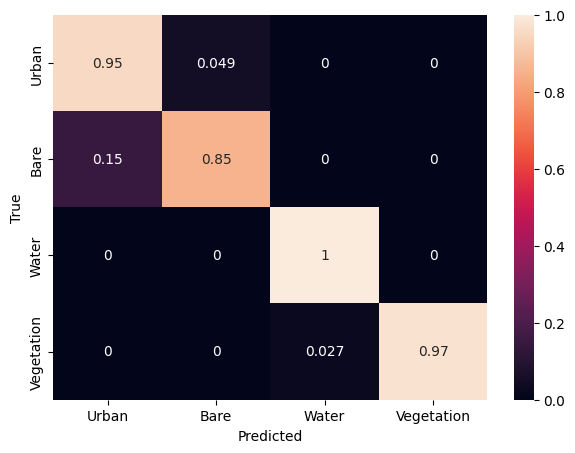

In [28]:
target_names = ['Urban', 'Bare', 'Water', 'Vegetation']
print(classification_report(testdf['landcover'], y_test_hat, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(testdf['landcover'], y_test_hat, normalize="true")

# Plot confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, xticklabels= target_names, yticklabels= target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 03. Improving the Classification

The Earth Engine data-model is especially well suited for ML tasks because of its ability to easily incorporate data sources of different spatial resolutions, projections and data types together By giving additional information to the classifier, it is able to separate different classes easily.

Here we take the same example and augment it with different spectral indices such as - NDVI, NDBI, MNDWI and BSI. We also add slope and elevation bands from the ALOS DEM.

The result is a much improve the classification.

In [29]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
basin = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_7")
gcp = ee.FeatureCollection("users/ujavalgandhi/e2e/arkavathy_gcps")
alos = ee.Image("JAXA/ALOS/AW3D30/V2_2")

arkavathy = basin.filter(ee.Filter.eq('HYBAS_ID', 4071139640))
boundary = arkavathy.geometry()
rgbVis = {
  "min": 0.0,
  "max": 3000,
  "bands": ['B4', 'B3', 'B2'],
}

def maskCloudAndShadowsSR(img):
    """Removes cloud and snow pixels from Sentinel-2 SR image."""
    cloudProb = img.select('MSK_CLDPRB')
    snowProb = img.select('MSK_SNWPRB')
    cloud = cloudProb.lt(10)
    scl = img.select('SCL')
    shadow = scl.eq(3)
    cirrus = scl.eq(10)

    # Cloud probability less than 10% or cloud shadow classification
    mask = cloud.And(cirrus.neq(1)).And(shadow.neq(1))
    return img.updateMask(mask).divide(10000)


filtered = s2\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
    .filter(ee.Filter.date('2019-01-01', '2019-12-31'))\
    .filter(ee.Filter.geometry(boundary))\
    .map(maskCloudAndShadowsSR)\
    .select('B.*')

composite = filtered.median().clip(boundary)

def addIndices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename(['ndvi'])# Vegetation index
    ndbi = img.normalizedDifference(['B11', 'B8']).rename(['ndbi'])# Built-up index
    mndwi = img.normalizedDifference(['B3', 'B11']).rename(['mndwi'])# Modified water index
    bsi = img.expression( #Bare soil inedex
      "(( X + Y ) - (A + B)) /(( X + Y ) + (A + B))", {
        "X": img.select("B11"),
        "Y": img.select("B4"),
        "A": img.select("B8"),
        "B": img.select("B2")
      }).rename("bsi")
    return img.addBands(ndvi).addBands(ndbi).addBands(mndwi).addBands(bsi)

composite = addIndices(composite)

elev = alos.select('AVE_DSM').divide(2000).rename('elev')
slope = ee.Terrain.slope(alos.select('AVE_DSM')).divide(30).rename('slope')

composite = composite.addBands([elev, slope])

visParams = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.2}
Map.addLayer(composite, visParams, 'RGB')

# Download composite image (takes ~ 5 minutes to download and mosaic)
filename = 'composite_03.tif'
if not os.path.exists(filename):
    geemap.download_ee_image(composite, filename, region = bangalore.geometry(),
                         scale=100, crs = 'EPSG:4326', unmask_value = -9999)

composite_03.tif: |          | 0.00/8.99M (raw) [  0.0%] in 00:00 (eta:     ?)

In [30]:
# Add a random column and split the GCPs into training and validation set
gcp = gcp.randomColumn(seed = 42)

# This being a simpler classification, we take 60% points
# for validation. Normal recommended ratio is
# 70% training, 30% validation
trainingGcp = gcp.filter(ee.Filter.lt('random', 0.6))
validationGcp = gcp.filter(ee.Filter.gte('random', 0.6))

# Overlay the point on the image to get training data.
training = composite.sampleRegions(**{
  "collection": trainingGcp,
  "properties": ['landcover'],
  "scale": 10,
  "tileScale": 16
})

# Train a classifier in GEE.
classifier = ee.Classifier.smileRandomForest(numberOfTrees = 50, seed = 42)\
    .train(**{
        "features": training,
        "classProperty": 'landcover',
        "inputProperties": composite.bandNames()
    })

# Classify the image.
classified = composite.classify(classifier)

Map.addLayer(classified, {"min": 0, "max": 3, "palette": ['gray', 'brown', 'blue', 'green']}, '2019')


In [32]:
# Extract data and reorder columns
traindf = geemap.ee_to_pandas(training)[composite.bandNames().add('landcover').getInfo()]

# Train a classifier.
classifier = RandomForestClassifier(n_estimators = 50, random_state = 42).fit(
    X = traindf.drop('landcover', axis=1), y = traindf[['landcover']])

# Run inference on the composite image using the trained model (takes ~30 seconds with a patch size of 512x 512 seconds)
inference(filename, classifier, 'classified_03.tif', 512)

classified_03.tif:   0%|          | 0/1 [00:00<?, ?it/s]

## Accuracy Assessment

              precision    recall  f1-score   support

       Urban       0.88      0.95      0.91        39
        Bare       0.95      0.88      0.91        40
       Water       0.97      0.90      0.94        40
  Vegetation       0.91      0.98      0.94        42

    accuracy                           0.93       161
   macro avg       0.93      0.92      0.93       161
weighted avg       0.93      0.93      0.93       161



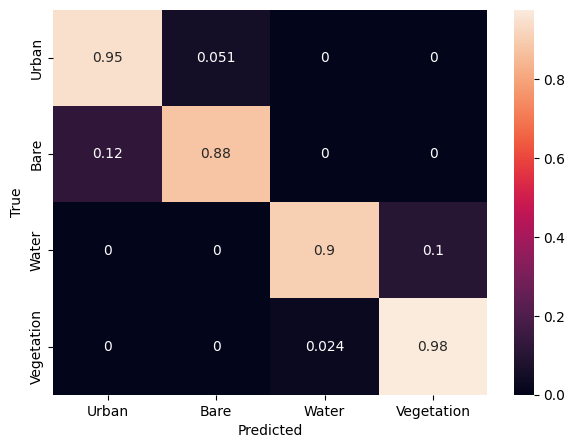

In [34]:
# Use classification map to assess accuracy using the validation fraction
# of the overall training set created above.
test = composite.sampleRegions(**{
  "collection": validationGcp,
  "properties": ['landcover'],
  "scale": 10,
  "tileScale": 16
})

testdf = geemap.ee_to_pandas(test)[composite.bandNames().add('landcover').getInfo()]
y_test_hat = classifier.predict(testdf.drop(['landcover'],axis=1))

target_names = ['Urban', 'Bare', 'Water', 'Vegetation']
print(classification_report(testdf['landcover'], y_test_hat, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(testdf['landcover'], y_test_hat, normalize="true")

# Plot confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, xticklabels= target_names, yticklabels= target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The addition of indices, elevation and the slope variable have slightly reduced the accuracy (93.8% vs 93.2%). Typically, the addition of covariates improves the accuracy, however, in this case it was not the outcome. When I used the default seed, there was a increase.

**Takeaway:** If you are presenting results in a research paper, it is therefore recommended that the mean(standard deviation) scores are reported across multiple randomly selected seeds.

## 04. Hyperparameter Tuning
An additional way to improve a models accuracy is by modifying the hyperparameters of a model. So how do we determine what values to choose? The answer is hyperparameter tuning.

For example, when using the ee.Classifier.smileRandomForest() classifier, we must specify the Number of Trees. We know that higher number of trees result in more computation requirement, but it doesn't necessarily result in better results.

Instead of guessing, we programmatically try a range of values and choose the smallest value possible that results in the highest accuracy.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define the hyperparameters space
param_grid = {
    'n_estimators': list(range(10, 160, 10))
}

# Randomized Search for hyperparameter tuning
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=param_grid, scoring= 'accuracy', verbose = 1, n_jobs = -1)
grid_search.fit(traindf.drop('landcover', axis=1), traindf[['landcover']])
print(grid_search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'n_estimators': 80}


              precision    recall  f1-score   support

       Urban       0.88      0.90      0.89        39
        Bare       0.90      0.88      0.89        40
       Water       0.97      0.90      0.94        40
  Vegetation       0.91      0.98      0.94        42

    accuracy                           0.91       161
   macro avg       0.91      0.91      0.91       161
weighted avg       0.91      0.91      0.91       161



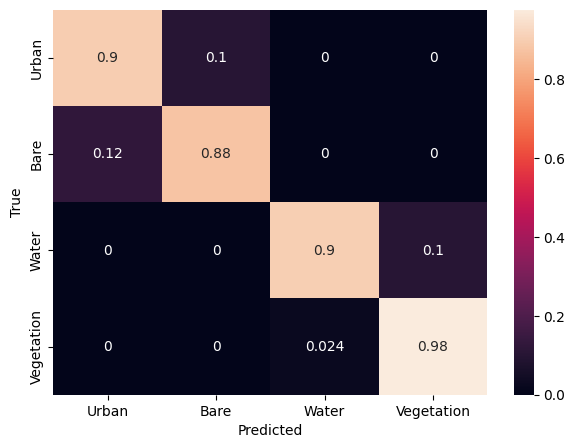

In [36]:
# Train a classifier.
classifier = RandomForestClassifier(random_state = 42, **grid_search.best_params_).fit(
    X = traindf.drop('landcover', axis=1), y = traindf[['landcover']])

y_test_hat = classifier.predict(testdf.drop(['landcover'],axis=1))

target_names = ['Urban', 'Bare', 'Water', 'Vegetation']
print(classification_report(testdf['landcover'], y_test_hat, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(testdf['landcover'], y_test_hat, normalize="true")

# Plot confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, xticklabels= target_names, yticklabels= target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
# Get the results of the randomized search
results = grid_search.cv_results_

# Extract n_estimators and corresponding mean test scores
n_estimators = results['param_n_estimators'].data
mean_test_scores = results['mean_test_score']

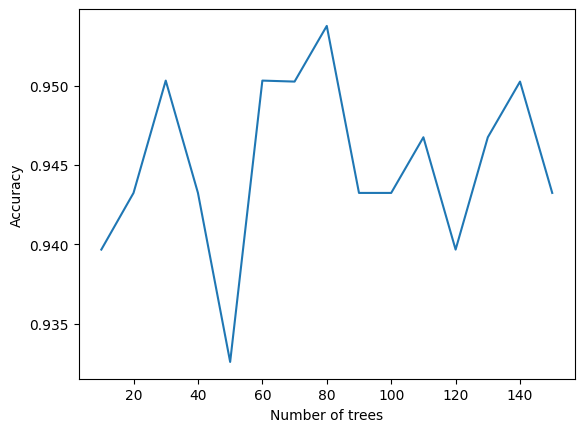

In [38]:
fig, ax = plt.subplots()
ax.plot(n_estimators, mean_test_scores)
ax.set_xlabel("Number of trees")
ax.set_ylabel("Accuracy")
plt.show()

## 05. Upload image classification results to GEE
At this point and the production of multiple classification maps. It may be beneficial to upload these to GEE so that you may carry out additional analysis or GEE as a way to share your data with other rsearchers and perhaps, even create a GEE app to improve the accessibility of your work. There are three main ways to upload your data to GEE.
1. A manual upload (For more information [refer here](https://developers.google.com/earth-engine/guides/image_upload)). This option is ideal for few rasters.
2. Using the Google cloud option (see above link)
3. Using the geeup tool (For more information [refer here](https://github.com/samapriya/geeup)). This option is free, however, it can be tricky to setup.

### Additional resources

- [Google Earth Engine book - Freely available](https://link.springer.com/book/10.1007/978-3-031-26588-4)
- [Qiusheng Wu's awesome GEE repo](https://gee-community-catalog.org/)

### Acknowledgements

- This tutorial relies heavily on the python ported version ([Found here](https://nbviewer.org/github/Akramz/end-to-end-gee/blob/main/4_Supervised_Classification_and_Change_Detection.ipynb)) of the supervised classification tutorial released by Ujaval
 Gandhi in his publicly available end-end Gooogle Earth Engine Javascript course ([Found here](https://courses.spatialthoughts.com/end-to-end-gee.html)).

- I would like to thank Stellenbosch university for supporting the development of this material.